# Bounding box demonstration
This notebook demonstrate:
1. the performance of the tissue bounding box calculation
2. the relevant plotting functions: polygon and delaunay plots 
3. its integration with other functions in `io` modules. 

### load in spateo package

In [1]:
import spateo as st

/Users/xqiu/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
In /Users/xqiu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/xqiu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/xqiu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallbac

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/xqiu/anaconda3/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/xqiu/anaconda3/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

import seaborn as sns
from descartes import PolygonPatch

- now `read_bgi_agg` has the `binsize` argument. 
- `read_bgi_agg` also returns `x_min` and `y_min` when the input data is not start from (0, 0)

Plot the UMI counts. Note with `bin1[0].A > 0`, only the nanoball with UMIs are colored red otherwise white

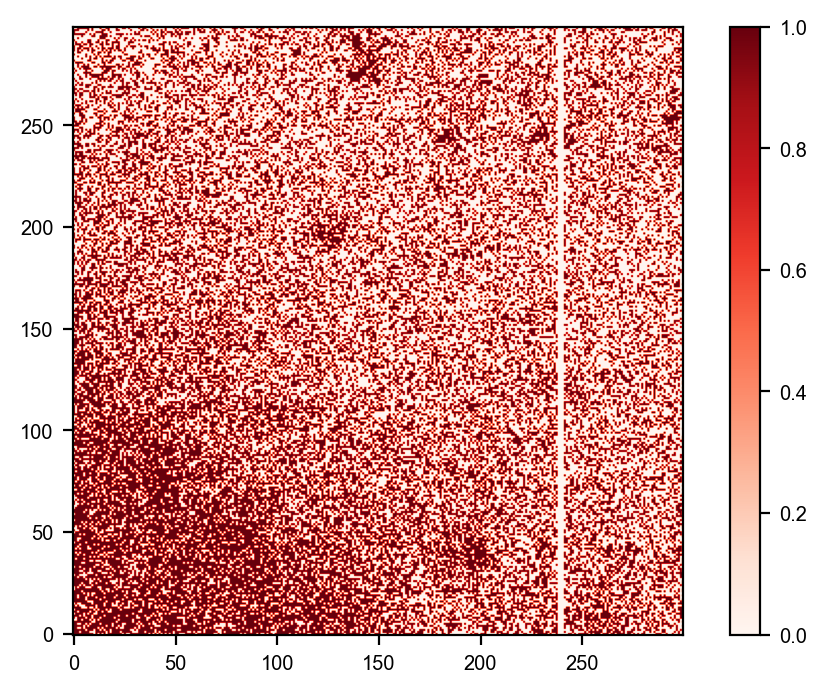

In [3]:
file_big = '/Users/xqiu/Dropbox/Projects/spateo-release/debug/SS200000135TL_D1_bin1.gem.gz'
file_small = '/Users/xqiu/Dropbox/Projects/spateo-release/tests/fixtures/bgi/SS200000135TL_D1_bin1_small.gem.gz'
file = file_small
bin1 = st.io.read_bgi_agg(file, binsize=1)
plt.imshow(bin1[0].A > 0, cmap='Reds', origin='lower')
plt.colorbar()

The forth and fifth element is the `x_min` and `y_min`

In [4]:
bin1

(<299x300 sparse matrix of type '<class 'numpy.uint16'>'
 	with 41915 stored elements in Compressed Sparse Row format>,
 None,
 None,
 9600,
 12600)

When we use `bin = 5`, all bucket has > 0 UMIs

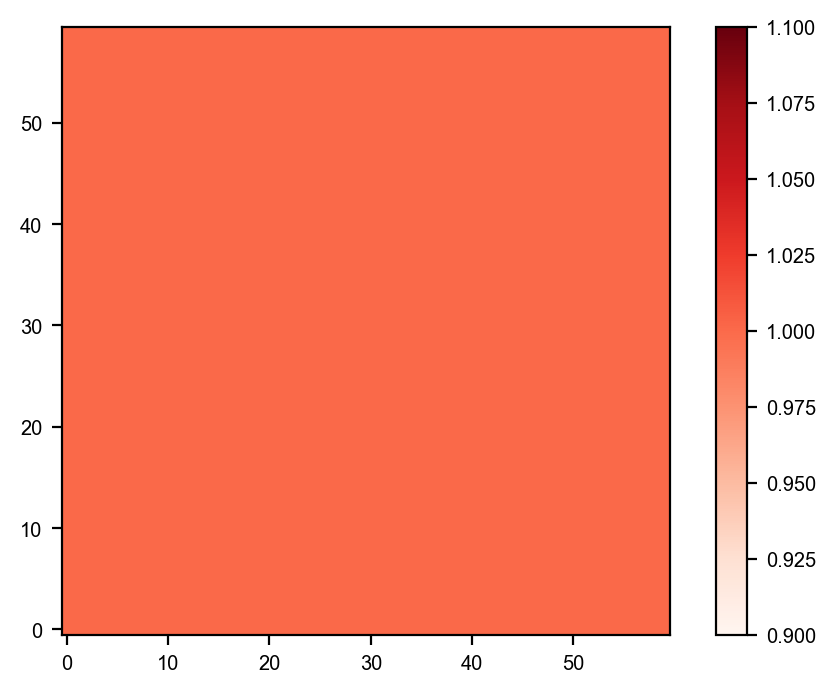

In [5]:
bin5 = st.io.read_bgi_agg(file, binsize=5)
plt.imshow(bin5[0].A > 0, cmap='Reds', origin='lower')
plt.colorbar()

### run `get_concave_hull` to get the concave hull
- Note that when the resultant concave hull is MultiPolygon, the biggest is in the first one (thus `alpha1[0][0]`)
- Note that the x/y coordinates are the true coordinates (instead the shifted ones from the `imshow` function)

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

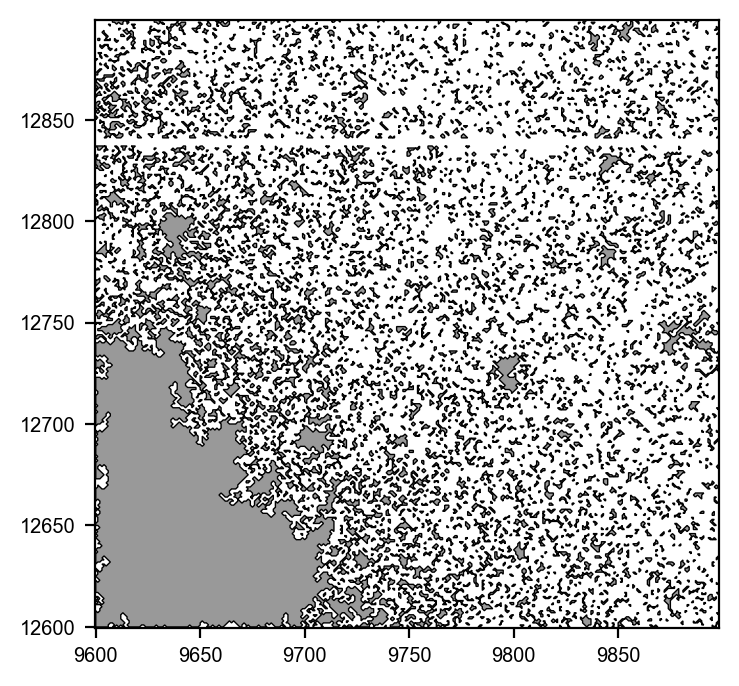

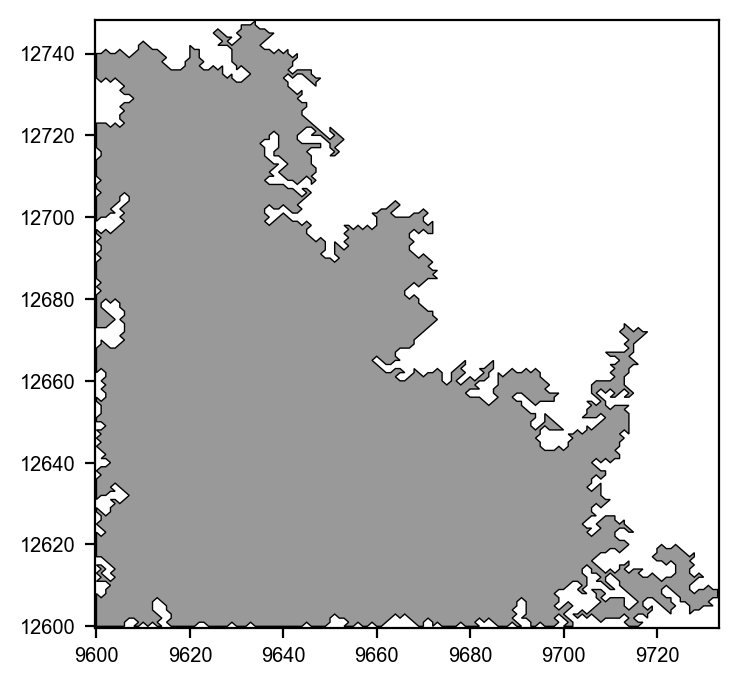

In [6]:
alpha1 = st.io.get_concave_hull(file, binsize=1)
st.pl.polygon(alpha1[0], figsize=(4, 4))
st.pl.polygon(alpha1[0][0], figsize=(4, 4))

### We can also plot the delaunay triangulation of the nanoball / bucket. 
- The triangulation are processed after identifying concave hull
- Each connected component corresponds to a single concave hull
- here we set the x/y lim to a small region because otherwise we can only see the points

(12770.0, 12820.0)

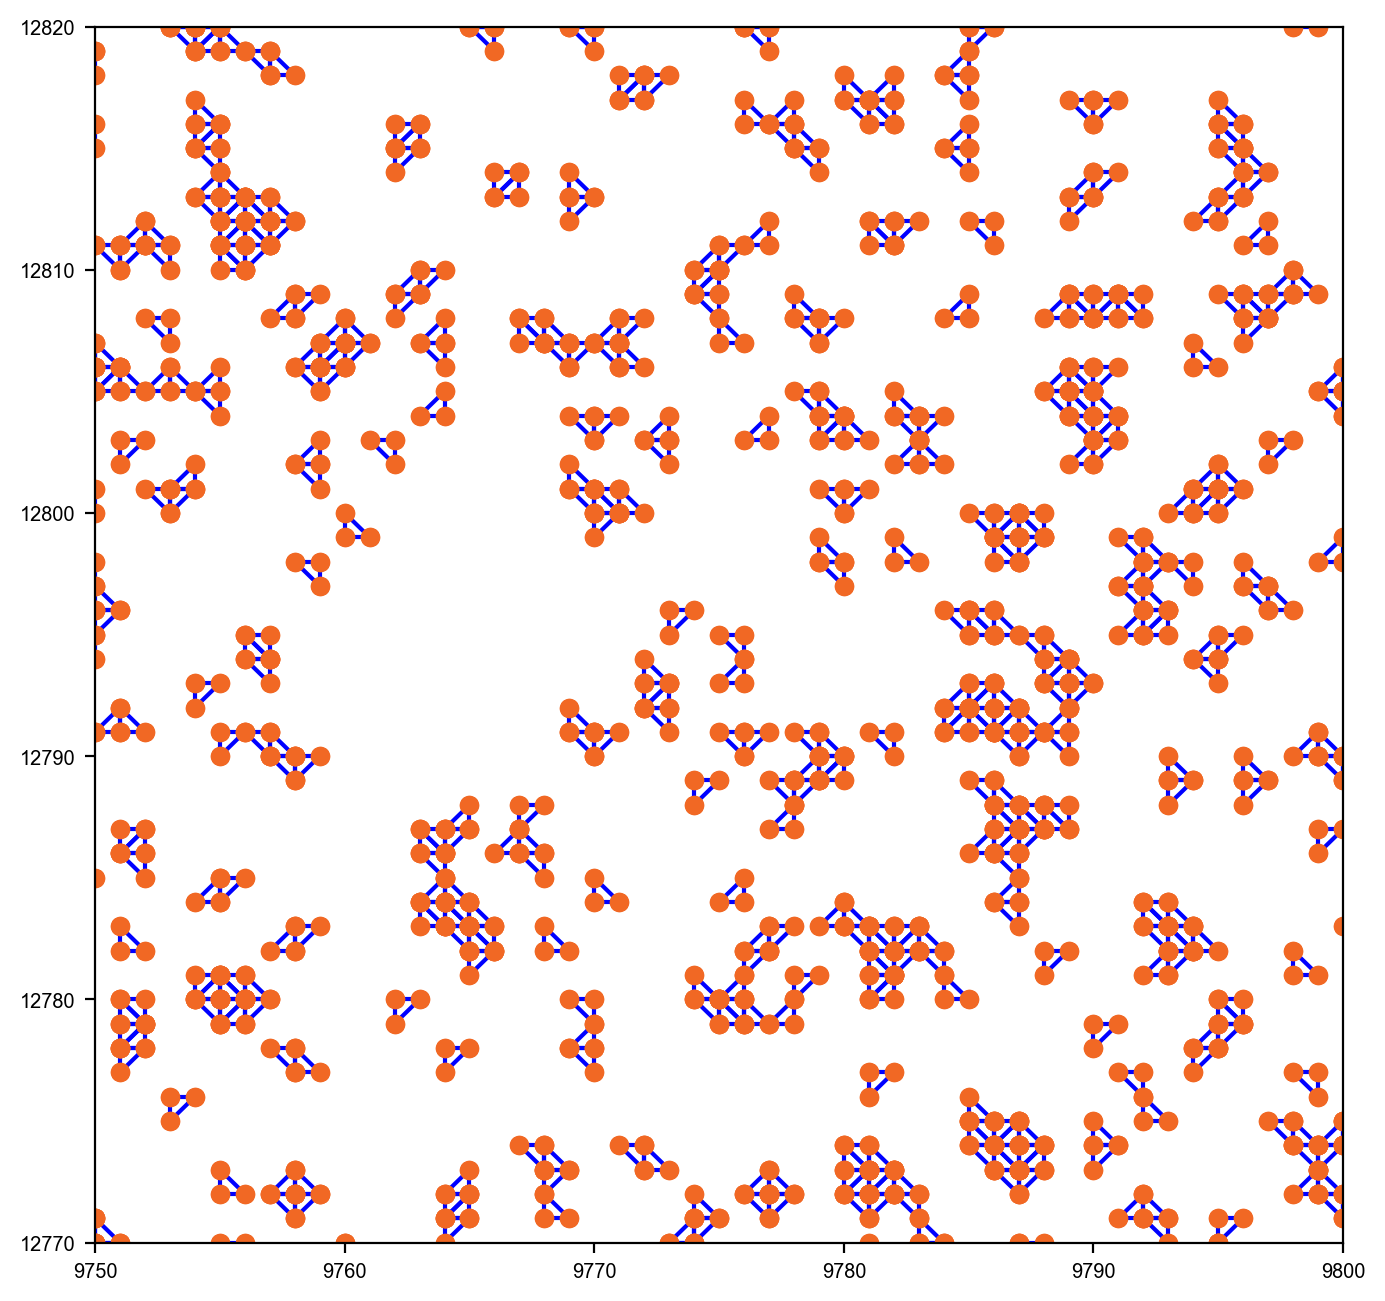

In [7]:
fig, ax = st.pl.delaunay(alpha1[1], figsize=(8, 8))

ax.set_xlim(9750, 9800)
ax.set_ylim(12770, 12820)

When the using `binsize=5`, all buckets have UMIs, so the resultant alpha hull is the entire rectangle space. 

- Note that since the resultant space is a rectangle, we need to set `alpha` to be very small (`alpha=0.01` in this case). 
- alpha value to influence the gooeyness of the border. Smaller numbers don't fall inward as much as larger numbers. Too large, and you lose everything!

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

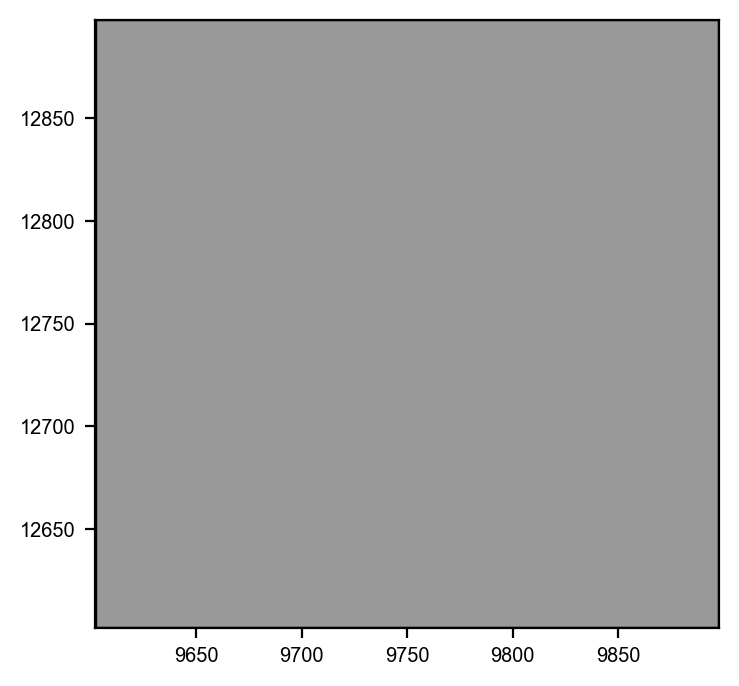

In [8]:
alpha_5_001 = st.io.get_concave_hull(file, binsize=5, alpha=0.01)
st.pl.polygon(alpha_5_001[0], figsize=(4, 4))

### The following code demonstrates how to use the alpha_hull argument in `read_bgi` function

In [9]:
adata1 = st.io.read_bgi(file, binsize=1, alpha_hull=None)
adata1

AnnData object with n_obs × n_vars = 41915 × 10631
    obs: 'contours', 'area', 'slice'
    obsm: 'spatial'

- note that we only used the first concave hull as the mask to create the adata object 
- otherwise it will take forever to check whether each cell in all those concave hulls (a few thousands in total)

In [10]:
adata_alpha1 = st.io.read_bgi(file, binsize=1, alpha_hull=alpha1[0][0])
adata_5_alpha1 = st.io.read_bgi(file, binsize=5, alpha_hull=alpha1[0][0])

adata_alpha1, adata_5_alpha1

(AnnData object with n_obs × n_vars = 8724 × 6788
     obs: 'contours', 'area', 'slice'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 520 × 6788
     obs: 'contours', 'area', 'slice'
     obsm: 'spatial')

*we can plot the contour because we used geoPands to keep the contours.*

It is the `concave hull` we identified before! 

<AxesSubplot:>

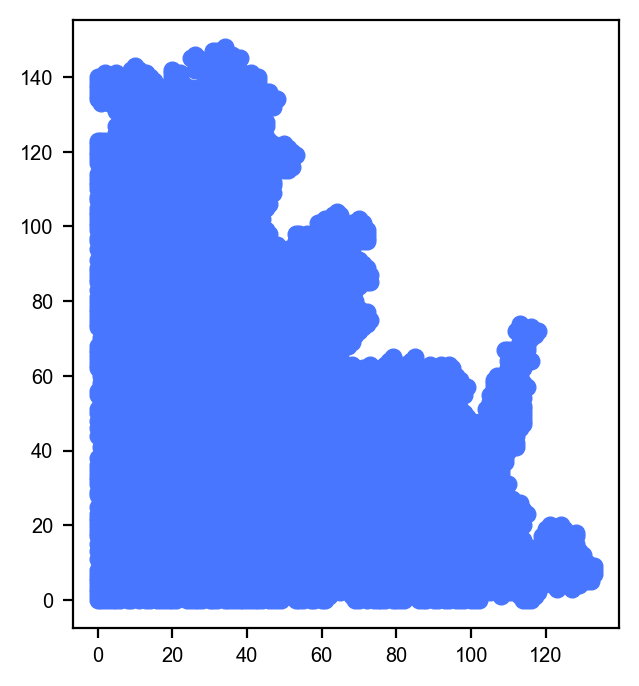

In [11]:
adata_alpha1.obs.contours.plot()

<AxesSubplot:>

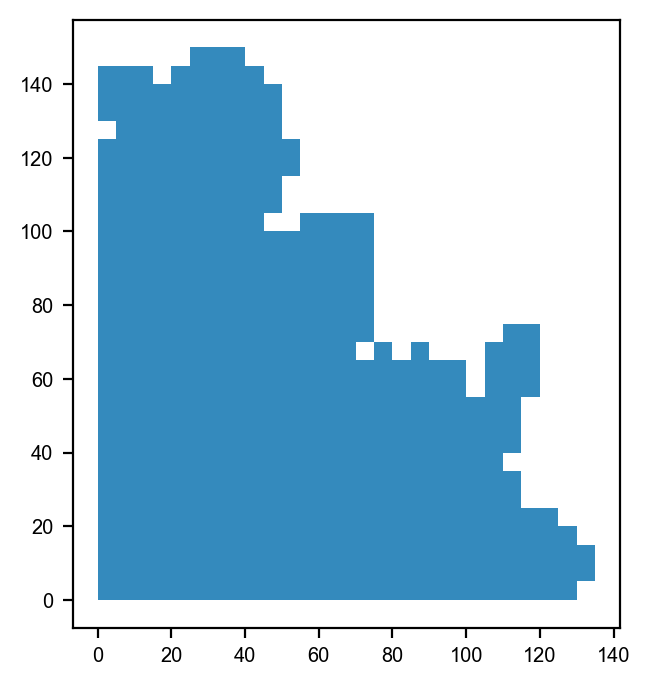

In [12]:
adata_5_alpha1.obs.contours.plot()

##### same as above, but use the concave hull identified with binsize = 5.
- note that there is only one concave hull so `alpha_5_001[0]` is used

In [13]:
adata_alpha_5_001 = st.io.read_bgi(file, binsize=1, alpha_hull=alpha_5_001[0])
adata_5_alpha_5_001 = st.io.read_bgi(file, binsize=5, alpha_hull=alpha_5_001[0])

adata_alpha_5_001, adata_5_alpha_5_001

(AnnData object with n_obs × n_vars = 40473 × 10536
     obs: 'contours', 'area', 'slice'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 3600 × 10536
     obs: 'contours', 'area', 'slice'
     obsm: 'spatial')

<AxesSubplot:>

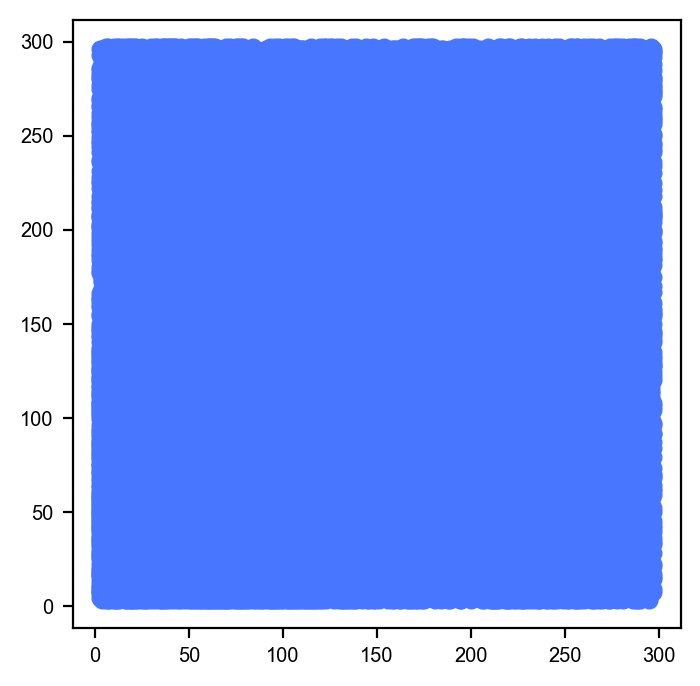

In [14]:
adata_alpha_5_001.obs.contours.plot()

<AxesSubplot:>

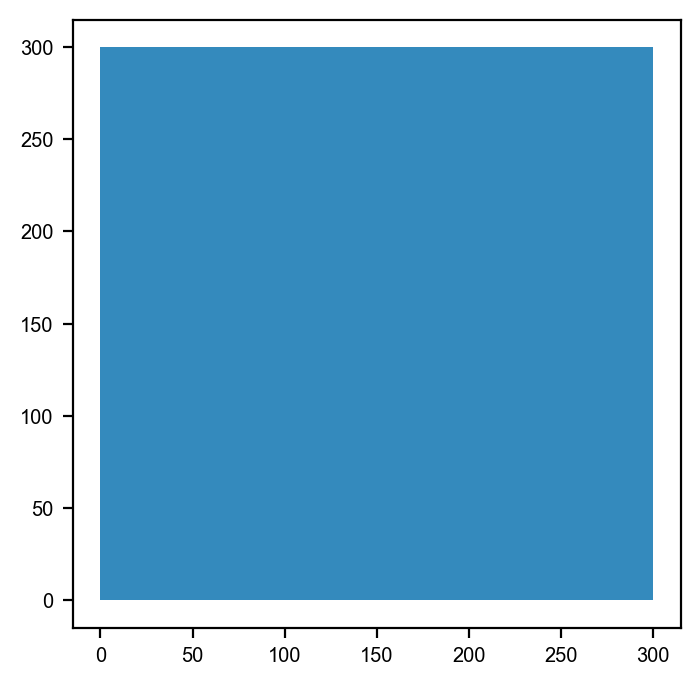

In [15]:
adata_5_alpha_5_001.obs.contours.plot()